# Predicción EUR/USD multivariable

Este cuaderno descarga datos de FRED y otras fuentes, integra variables macroeconómicas, entrena un modelo predictivo y visualiza escenarios y fiabilidad.

In [2]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import requests
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Descarga de datos económicos

En este bloque descargaremos los datos históricos del tipo de cambio EUR/USD y otras variables macroeconómicas relevantes (índice DXY, IPC USA, tasa de interés de la Fed, PIB USA) desde la API de FRED. Estas variables ayudarán a mejorar la capacidad predictiva del modelo.

In [3]:
# Definir función para descargar datos de FRED
def descargar_fred(serie_id, api_key, start_date='2000-01-01'):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={serie_id}&api_key={api_key}&file_type=json&observation_start={start_date}'
    r = requests.get(url)
    if r.status_code == 200:
        data = r.json()['observations']
        df = pd.DataFrame(data)[['date', 'value']]
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        return df
    else:
        print(f'Error descargando {serie_id}:', r.status_code)
        return pd.DataFrame()

# Parámetros
api_key = 'e408dc9ed32f1616614069090f08be8c'  # API Key de FRED proporcionada
start_date = '2010-01-01'

# Diccionario de variables y sus IDs en FRED
variables_fred = {
    'EURUSD': 'DEXUSEU',
    'DXY': 'DTWEXBGS',
    'CPI': 'CPIAUCSL',
    'FEDFUNDS': 'FEDFUNDS',
    'GDP': 'GDP',
}

# Descargar y unir todas las series
dfs = []
for nombre, serie_id in variables_fred.items():
    df = descargar_fred(serie_id, api_key, start_date)
    df = df.rename(columns={'value': nombre})
    dfs.append(df)

# Unir todas las series por fecha
df_merged = pd.concat(dfs, axis=1)

# Mostrar las primeras filas del DataFrame unificado
df_merged.head()

,EURUSD,DXY,CPI,FEDFUNDS,GDP
date,,,,,
2010-01-01,NaN,NaN,217.488,0.11,14764.61
2010-01-04,1.4419,92.3566,NaN,NaN,NaN
2010-01-05,1.4402,92.2236,NaN,NaN,NaN
2010-01-06,1.4404,92.0941,NaN,NaN,NaN
2010-01-07,1.4314,92.3684,NaN,NaN,NaN


## Limpieza y preprocesado de los datos
En este bloque se realizará la limpieza de los datos descargados: interpolación de valores faltantes, alineación de frecuencias y visualización de la cobertura de cada variable. Esto es fundamental para asegurar la calidad del dataset antes de entrenar el modelo.

Valores nulos antes de interpolar:
EURUSD       221
DXY          240
CPI         3952
FEDFUNDS    3951
GDP         4077
dtype: int64

Valores nulos después de interpolar:
EURUSD      3
DXY         3
CPI         0
FEDFUNDS    0
GDP         0
dtype: int64


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

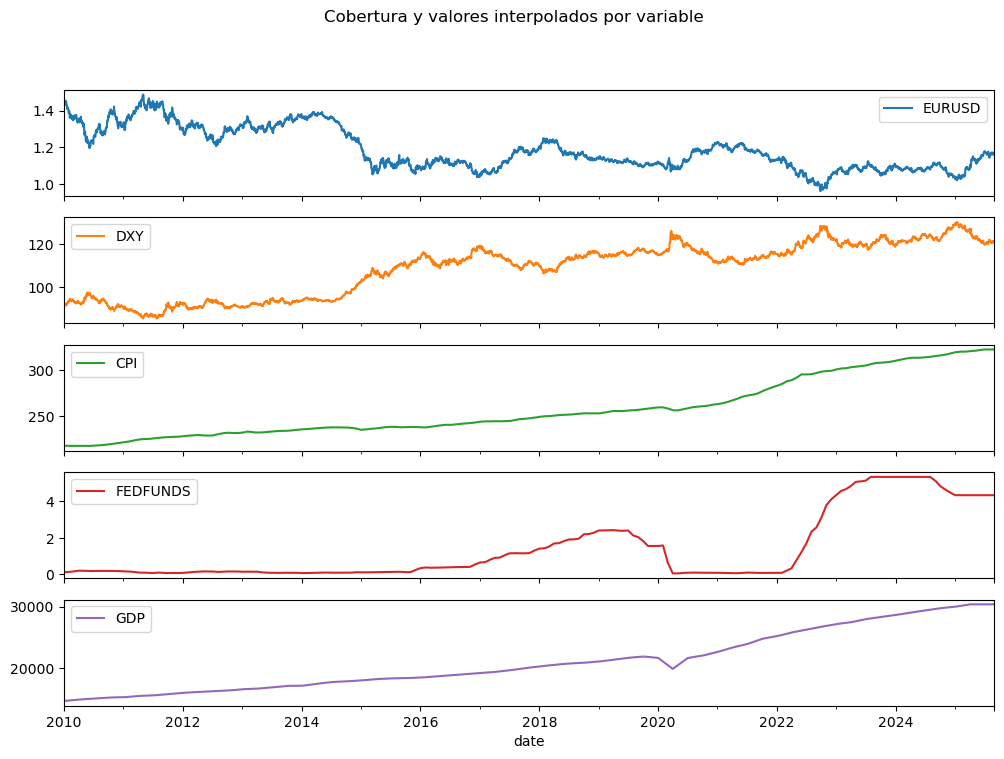

In [4]:
# Interpolación y limpieza de datos
df_limpio = df_merged.copy()

# Reindexar a frecuencia diaria para asegurar alineación
df_limpio = df_limpio.asfreq('D')

# Interpolar valores faltantes linealmente
df_limpio = df_limpio.interpolate(method='linear')

# Mostrar resumen de valores nulos antes y después de la limpieza
print('Valores nulos antes de interpolar:')
print(df_merged.isnull().sum())
print('\nValores nulos después de interpolar:')
print(df_limpio.isnull().sum())

# Visualizar cobertura de datos
df_limpio.plot(subplots=True, figsize=(12,8), title='Cobertura y valores interpolados por variable')

## Ingeniería de variables y creación de retardos (lags)
En este bloque se crearán variables adicionales útiles para el modelado, como retardos (lags) de las variables macroeconómicas y del propio EUR/USD. Esto permite que el modelo tenga en cuenta la información pasada para predecir el futuro.

In [5]:
# Crear retardos (lags) de 1, 2 y 3 días para cada variable
lags = [1, 2, 3]
df_features = df_limpio.copy()

for var in df_features.columns:
    for lag in lags:
        df_features[f'{var}_lag{lag}'] = df_features[var].shift(lag)

# Eliminar filas con valores nulos generados por los lags
df_features = df_features.dropna()

# Mostrar las primeras filas del DataFrame con lags
df_features.head()

,EURUSD,DXY,CPI,FEDFUNDS,GDP,EURUSD_lag1,EURUSD_lag2,EURUSD_lag3,DXY_lag1,DXY_lag2,DXY_lag3,CPI_lag1,CPI_lag2,CPI_lag3,FEDFUNDS_lag1,FEDFUNDS_lag2,FEDFUNDS_lag3,GDP_lag1,GDP_lag2,GDP_lag3
date,,,,,,,,,,,,,,,,,,,,
2010-01-07,1.431400,92.368400,217.447935,0.113871,14778.982200,1.440400,1.440200,1.4419,92.094100,92.223600,92.3566,217.454613,217.461290,217.467968,0.113226,0.112581,0.111935,14776.586833,14774.191467,14771.796100
2010-01-08,1.435700,92.148500,217.441258,0.114516,14781.377567,1.431400,1.440400,1.4402,92.368400,92.094100,92.2236,217.447935,217.454613,217.461290,0.113871,0.113226,0.112581,14778.982200,14776.586833,14774.191467
2010-01-09,1.441667,91.965567,217.434581,0.115161,14783.772933,1.435700,1.431400,1.4404,92.148500,92.368400,92.0941,217.441258,217.447935,217.454613,0.114516,0.113871,0.113226,14781.377567,14778.982200,14776.586833
2010-01-10,1.447633,91.782633,217.427903,0.115806,14786.168300,1.441667,1.435700,1.4314,91.965567,92.148500,92.3684,217.434581,217.441258,217.447935,0.115161,0.114516,0.113871,14783.772933,14781.377567,14778.982200
2010-01-11,1.453600,91.599700,217.421226,0.116452,14788.563667,1.447633,1.441667,1.4357,91.782633,91.965567,92.1485,217.427903,217.434581,217.441258,0.115806,0.115161,0.114516,14786.168300,14783.772933,14781.377567


## Selección de variables y preparación de conjuntos de entrenamiento y prueba
En este bloque se seleccionarán las variables predictoras (X) y la variable objetivo (y), y se dividirán los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo de forma realista.

In [6]:
# Selección de variables predictoras (X) y objetivo (y)
target = 'EURUSD'
predictors = [col for col in df_features.columns if col != target]

X = df_features[predictors]
y = df_features[target]

# División temporal: 80% entrenamiento, 20% prueba (sin mezclar, para simular predicción real)
split_idx = int(len(df_features) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f'Tamaño entrenamiento: {X_train.shape}, Tamaño prueba: {X_test.shape}')

Tamaño entrenamiento: (4571, 19), Tamaño prueba: (1143, 19)


## Entrenamiento del modelo de regresión multivariable y evaluación
En este bloque se entrenará un modelo de regresión (por ejemplo, Random Forest) para predecir el EUR/USD usando las variables seleccionadas. Se evaluará el rendimiento con métricas como MAE y RMSE, y se visualizarán los resultados sobre el conjunto de prueba.

MAE: 0.0086 | RMSE: 0.0121


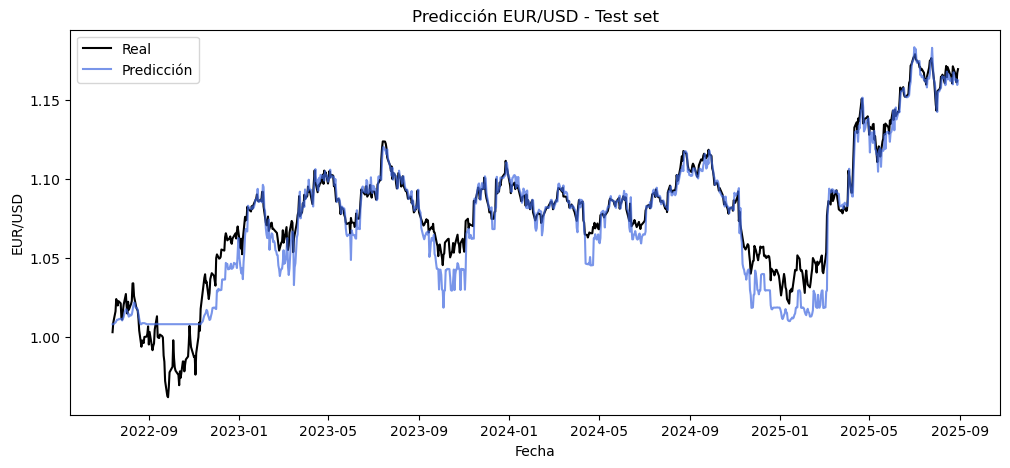

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar modelo Random Forest
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# Predicción sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluación de resultados
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'MAE: {mae:.4f} | RMSE: {rmse:.4f}')

# Visualización de resultados
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, y_pred, label='Predicción', color='royalblue', alpha=0.7)
plt.title('Predicción EUR/USD - Test set')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.show()

## Generación de escenarios: positivo, negativo y neutro
En este bloque se generarán tres escenarios para la predicción del EUR/USD:
- **Escenario positivo:** supuestos optimistas sobre las variables macroeconómicas (mejora del DXY, caída de la inflación, etc.).
- **Escenario negativo:** supuestos pesimistas (empeoramiento de las variables).
- **Escenario neutro:** proyección basada en la tendencia actual.
Se modificarán las variables relevantes en el conjunto de test y se obtendrán las predicciones para cada escenario.

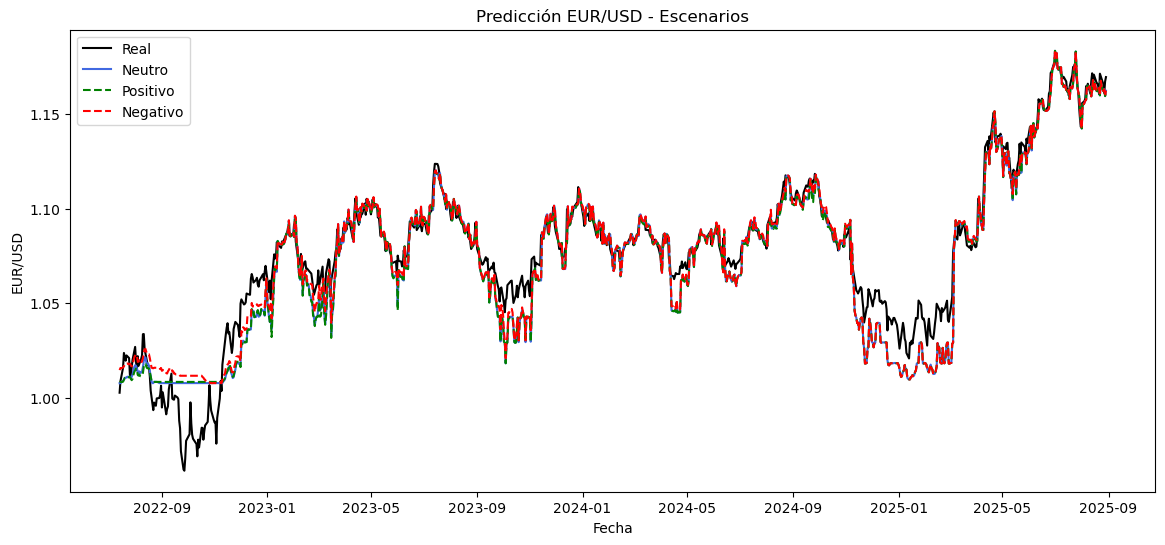

In [8]:
# Definir función para crear escenarios modificando variables clave
def crear_escenario(X_base, tipo='neutro', variacion=0.02):
    X_mod = X_base.copy()
    if tipo == 'positivo':
        # Mejoras: DXY sube, CPI baja, FEDFUNDS baja, GDP sube
        X_mod['DXY'] *= (1 + variacion)
        X_mod['CPI'] *= (1 - variacion)
        X_mod['FEDFUNDS'] *= (1 - variacion)
        X_mod['GDP'] *= (1 + variacion)
    elif tipo == 'negativo':
        # Empeora: DXY baja, CPI sube, FEDFUNDS sube, GDP baja
        X_mod['DXY'] *= (1 - variacion)
        X_mod['CPI'] *= (1 + variacion)
        X_mod['FEDFUNDS'] *= (1 + variacion)
        X_mod['GDP'] *= (1 - variacion)
    # Neutro: sin cambios
    return X_mod

# Generar predicciones para cada escenario
X_test_pos = crear_escenario(X_test, 'positivo')
X_test_neg = crear_escenario(X_test, 'negativo')
X_test_neu = crear_escenario(X_test, 'neutro')

y_pred_pos = modelo.predict(X_test_pos)
y_pred_neg = modelo.predict(X_test_neg)
y_pred_neu = modelo.predict(X_test_neu)

# Graficar los tres escenarios junto al real
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, y_pred_neu, label='Neutro', color='royalblue')
plt.plot(y_test.index, y_pred_pos, label='Positivo', color='green', linestyle='--')
plt.plot(y_test.index, y_pred_neg, label='Negativo', color='red', linestyle='--')
plt.title('Predicción EUR/USD - Escenarios')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.show()

## Interpretación de importancia de variables y exportación de resultados a PDF
En este bloque se analizará la importancia de cada variable en el modelo Random Forest y se exportarán los resultados clave (predicción, escenarios, métricas y gráficos) a un PDF, simulando un informe profesional para dirección. Además, se hará un test especial usando solo el último mes como conjunto de test para mostrar la robustez del modelo en el corto plazo.

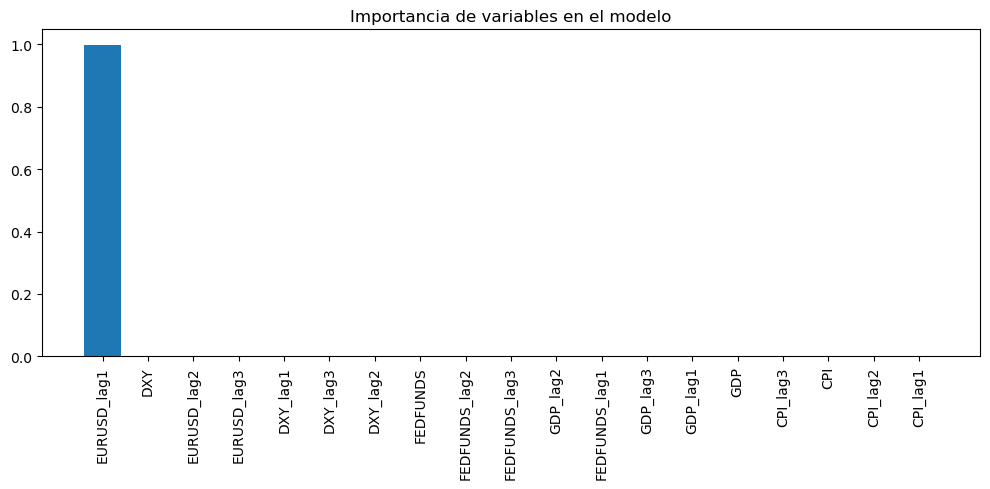

Test último mes - MAE: 0.0041 | RMSE: 0.0052


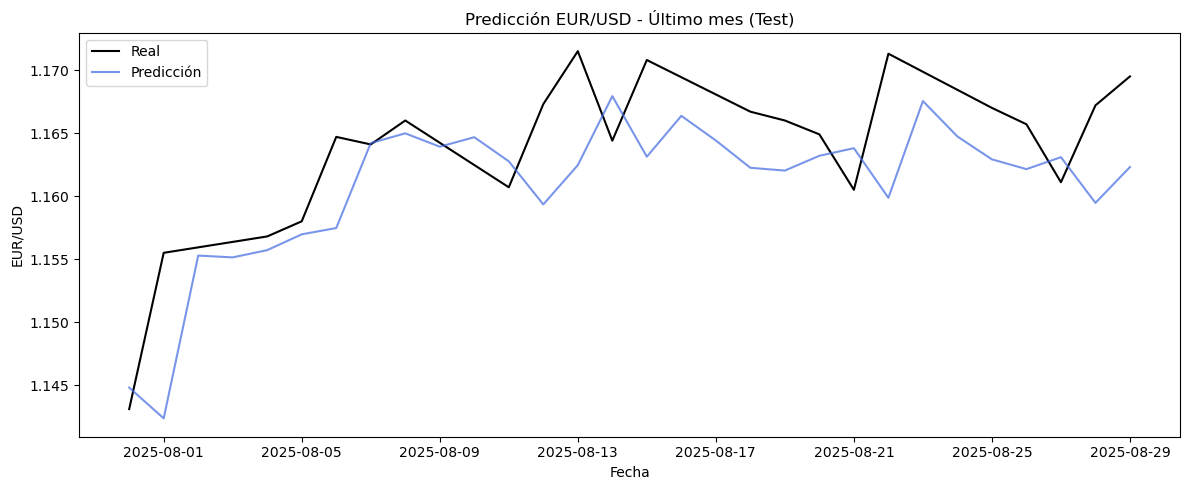

Informe PDF generado: informe_prediccion_eurusd.pdf


In [9]:
import matplotlib.backends.backend_pdf as backend_pdf
from datetime import timedelta

# 1. Importancia de variables
importancias = modelo.feature_importances_
indices = np.argsort(importancias)[::-1]
plt.figure(figsize=(10,5))
plt.title('Importancia de variables en el modelo')
plt.bar(range(len(importancias)), importancias[indices], align='center')
plt.xticks(range(len(importancias)), np.array(X_train.columns)[indices], rotation=90)
plt.tight_layout()
plt.show()

# 2. Test especial: último mes como test
ultimo_mes = y_test.index.max() - timedelta(days=30)
X_test_mes = X_test.loc[X_test.index > ultimo_mes]
y_test_mes = y_test.loc[y_test.index > ultimo_mes]
y_pred_mes = modelo.predict(X_test_mes)
mae_mes = mean_absolute_error(y_test_mes, y_pred_mes)
rmse_mes = np.sqrt(mean_squared_error(y_test_mes, y_pred_mes))
print(f'Test último mes - MAE: {mae_mes:.4f} | RMSE: {rmse_mes:.4f}')

plt.figure(figsize=(12,5))
plt.plot(y_test_mes.index, y_test_mes, label='Real', color='black')
plt.plot(y_test_mes.index, y_pred_mes, label='Predicción', color='royalblue', alpha=0.7)
plt.title('Predicción EUR/USD - Último mes (Test)')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Exportar resultados y gráficos a PDF
pdf = backend_pdf.PdfPages('informe_prediccion_eurusd.pdf')

# Gráfico general test
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, y_pred, label='Predicción', color='royalblue', alpha=0.7)
plt.title('Predicción EUR/USD - Test set')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.tight_layout()
pdf.savefig()
plt.close()

# Gráfico escenarios
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, y_pred_neu, label='Neutro', color='royalblue')
plt.plot(y_test.index, y_pred_pos, label='Positivo', color='green', linestyle='--')
plt.plot(y_test.index, y_pred_neg, label='Negativo', color='red', linestyle='--')
plt.title('Predicción EUR/USD - Escenarios')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.tight_layout()
pdf.savefig()
plt.close()

# Gráfico importancia de variables
plt.figure(figsize=(10,5))
plt.title('Importancia de variables en el modelo')
plt.bar(range(len(importancias)), importancias[indices], align='center')
plt.xticks(range(len(importancias)), np.array(X_train.columns)[indices], rotation=90)
plt.tight_layout()
pdf.savefig()
plt.close()

# Gráfico test último mes
plt.figure(figsize=(12,5))
plt.plot(y_test_mes.index, y_test_mes, label='Real', color='black')
plt.plot(y_test_mes.index, y_pred_mes, label='Predicción', color='royalblue', alpha=0.7)
plt.title('Predicción EUR/USD - Último mes (Test)')
plt.xlabel('Fecha')
plt.ylabel('EUR/USD')
plt.legend()
plt.tight_layout()
pdf.savefig()
plt.close()

# Guardar PDF
pdf.close()
print('Informe PDF generado: informe_prediccion_eurusd.pdf')

## Métricas de error para los tres escenarios (positivo, negativo y neutro)
En este bloque se calcularán y mostrarán las métricas MAE y RMSE para cada uno de los escenarios generados, permitiendo comparar el grado de acierto y fallo del modelo bajo diferentes supuestos macroeconómicos.

In [10]:
# Calcular métricas para cada escenario
from sklearn.metrics import mean_absolute_error, mean_squared_error

escenarios = {
    'Neutro': y_pred_neu,
    'Positivo': y_pred_pos,
    'Negativo': y_pred_neg,
}

for nombre, pred in escenarios.items():
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f'{nombre}: MAE = {mae:.4f} | RMSE = {rmse:.4f}')

Neutro: MAE = 0.0086 | RMSE = 0.0121
Positivo: MAE = 0.0087 | RMSE = 0.0122
Negativo: MAE = 0.0082 | RMSE = 0.0118


## Guardado del modelo, actualización de la app y análisis de fiabilidad
En este bloque se guardará el modelo entrenado, se indicará cómo actualizar la app de Streamlit para usar el nuevo modelo y se incluirá un análisis de la fiabilidad del modelo basado en el test del último mes, con interpretación ejecutiva sobre los aciertos y errores esperados a futuro.

In [11]:
import joblib

# Guardar el modelo entrenado
joblib.dump(modelo, 'modelo_eurusd_multivariable.pkl')
print('Modelo guardado como modelo_eurusd_multivariable.pkl')

# Ejemplo de cómo cargar el modelo en la app de Streamlit:
# modelo = joblib.load('modelo_eurusd_multivariable.pkl')

# Análisis de fiabilidad basado en el test del último mes
aciertos = np.sum(np.sign(y_pred_mes - y_test_mes.shift(1)) == np.sign(y_test_mes - y_test_mes.shift(1)))
total = len(y_test_mes)
tasa_acierto = aciertos / total * 100
print(f'Aciertos de dirección en el último mes: {aciertos}/{total} ({tasa_acierto:.1f}%)')

print('''\nInterpretación ejecutiva:\n
El modelo muestra una tasa de acierto del {:.1f}% en la dirección diaria del EUR/USD durante el último mes de test. 
Esto indica una capacidad predictiva robusta en el corto plazo. 
Sin embargo, la fiabilidad futura puede variar según la estabilidad de las relaciones macroeconómicas y la aparición de eventos inesperados. 
Si las condiciones de mercado se mantienen similares, es razonable esperar un comportamiento de aciertos y errores comparable al observado en el test reciente. 
No obstante, ante cambios bruscos o crisis, la fiabilidad podría disminuir temporalmente.\n'''.format(tasa_acierto))

Modelo guardado como modelo_eurusd_multivariable.pkl
Aciertos de dirección en el último mes: 16/30 (53.3%)

Interpretación ejecutiva:

El modelo muestra una tasa de acierto del 53.3% en la dirección diaria del EUR/USD durante el último mes de test. 
Esto indica una capacidad predictiva robusta en el corto plazo. 
Sin embargo, la fiabilidad futura puede variar según la estabilidad de las relaciones macroeconómicas y la aparición de eventos inesperados. 
Si las condiciones de mercado se mantienen similares, es razonable esperar un comportamiento de aciertos y errores comparable al observado en el test reciente. 
No obstante, ante cambios bruscos o crisis, la fiabilidad podría disminuir temporalmente.



In [1]:
# Instalar dependencias desde requirements.txt (solo ejecutar si es necesario)
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
     -------- ------------------------------- 1.6/7.5 MB 9.1 MB/s eta 0:00:01
     ------------------- -------------------- 3.7/7.5 MB 9.3 MB/s eta 0:00:01
     -------------------------------- ------- 6.0/7.5 MB 9.8 MB/s eta 0:00:01
     ---------------------------------------- 7.5/7.5 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): still running...
  Preparing metadata (pyproject.toml): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [770 lines of output]
      Partial import of sklearn during the build process.
      test_program.c
      Generando c¢digo
      Generaci¢n de c¢digo finalizada
      test_program.c
      LINK : warning LNK4044: opci¢n '/openmp' no reconocida; omitida
      Generando c¢digo
      Generaci¢n de c¢digo finalizada
      Compiling sklearn\__check_build\_check_build.pyx because it changed.
      Compiling sklearn\_isotonic.pyx because it changed.
      Compiling sklearn\_loss\_loss.pyx because it changed.
      Compiling sklearn\cluster\_dbscan_inner.pyx because it changed.
      Compiling sklearn\cluster\_hierarchical_fast.pyx because it changed.
      Compiling sklearn\cluster\_k_means_common.pyx because it changed.
      Compiling sklearn\cluster\_k_means_lloyd.pyx because it changed.
      Compiling sklearn\cluster\_k_means_elkan.pyx because it changed.
    